# Deep Q-Learning - Lunar Lander

In this assignment, you will train an agent to land a lunar lander safely on a landing pad on the surface of the moon.

Reference: https://www.gymlibrary.dev/environments/box2d/lunar_lander/

# Outline
- [ 1 - Import Packages <img align="Right" src="./images/lunar_lander.gif" width = 60% >](#1)
- [ 2 - Hyperparameters](#2)
- [ 3 - The Lunar Lander Environment](#3)
  - [ 3.1 Action Space](#3.1)
  - [ 3.2 Observation Space](#3.2)
  - [ 3.3 Rewards](#3.3)
  - [ 3.4 Episode Termination](#3.4)
- [ 4 - Load the Environment](#4)
- [ 5 - Interacting with the Gym Environment](#5)
    - [ 5.1 Exploring the Environment's Dynamics](#5.1)
- [ 6 - Deep Q-Learning](#6)
  - [ 6.1 Target Network](#6.1)
    - [ Exercise 1](#ex01)
  - [ 6.2 Experience Replay](#6.2)
- [ 7 - Deep Q-Learning Algorithm with Experience Replay](#7)
  - [ Exercise 2](#ex02)
- [ 8 - Update the Network Weights](#8)
- [ 9 - Train the Agent](#9)
- [ 10 - See the Trained Agent In Action](#10)
- [ 11 - Congratulations!](#11)
- [ 12 - References](#12)

<a name="1"></a>
## 1 - Import Packages

We'll make use of the following packages:
- `numpy` is a package for scientific computing in python.
- `deque` will be our data structure for our memory buffer.
- `namedtuple` will be used to store the experience tuples.
- The `gym` toolkit is a collection of environments that can be used to test reinforcement learning algorithms.
- `PIL.Image` and `pyvirtualdisplay` are needed to render the Lunar Lander environment.
- We will use several modules from the `torch.nn` framework for building deep learning models.
- `utils` is a module that contains helper functions for this assignment. You do not need to modify the code in this file.

Run the cell below to import all the necessary packages.

In [1]:
!apt-get install -y x11-utils xvfb python-opengl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl


In [2]:
!pip install pillow
!pip install imageio
!pip install matplotlib
!pip install pandas
!pip install statsmodels

In [3]:
!pip install swig
!pip install imageio[ffmpeg] 
!pip install gym pyvirtualdisplay pyglet 
!pip install gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 48.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.0/841.0 kB 19.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.2 MB/s eta 0:00:0000:0100:01
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=495297 sha256=7d15bd91da1f1b3c3325a224882cd076affce9f2463ddf06326f7343c1a31447
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [4]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image

from pyvirtualdisplay import Display
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import base64
import random
from itertools import zip_longest

import imageio
import IPython
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import torch
from statsmodels.iolib.table import SimpleTable

SEED = 0  # Seed for the pseudo-random number generator.
MINIBATCH_SIZE = 64  # Mini-batch size.
TAU = 1e-3  # Soft update parameter.
E_DECAY = 0.995  # ε-decay rate for the ε-greedy policy.
E_MIN = 0.01  # Minimum ε value for the ε-greedy policy.

random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def check_update_conditions(t, num_steps_upd, memory_buffer):
    """
    Determines if the conditions are met to perform a learning update.

    Checks if the current time step t is a multiple of num_steps_upd and if the
    memory_buffer has enough experience tuples to fill a mini-batch (for example, if the
    mini-batch size is 64, then the memory buffer should have more than 64 experience
    tuples in order to perform a learning update).
    
    Args:
        t (int):
            The current time step.
        num_steps_upd (int):
            The number of time steps used to determine how often to perform a learning
            update. A learning update is only performed every num_steps_upd time steps.
        memory_buffer (deque):
            A deque containing experiences. The experiences are stored in the memory
            buffer as namedtuples: namedtuple("Experience", field_names=["state",
            "action", "reward", "next_state", "done"]).

    Returns:
       A boolean that will be True if conditions are met and False otherwise. 
    """

    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False


def get_new_eps(epsilon):
    """
    Updates the epsilon value for the ε-greedy policy.
    
    Gradually decreases the value of epsilon towards a minimum value (E_MIN) using the
    given ε-decay rate (E_DECAY).

    Args:
        epsilon (float):
            The current value of epsilon.

    Returns:
       A float with the updated value of epsilon.
    """

    return max(E_MIN, E_DECAY * epsilon)



def plot_history(point_history, **kwargs):
    """
    Plots the total number of points received by the agent after each episode together
    with the moving average (rolling mean). 

    Args:
        point_history (list):
            A list containing the total number of points the agent received after each
            episode.
        **kwargs: optional
            window_size (int):
                Size of the window used to calculate the moving average (rolling mean).
                This integer determines the fixed number of data points used for each
                window. The default window size is set to 10% of the total number of
                data points in point_history, i.e. if point_history has 200 data points
                the default window size will be 20.
            lower_limit (int):
                The lower limit of the x-axis in data coordinates. Default value is 0.
            upper_limit (int):
                The upper limit of the x-axis in data coordinates. Default value is
                len(point_history).
            plot_rolling_mean_only (bool):
                If True, only plots the moving average (rolling mean) without the point
                history. Default value is False.
            plot_data_only (bool):
                If True, only plots the point history without the moving average.
                Default value is False.
    """

    lower_limit = 0
    upper_limit = len(point_history)

    window_size = (upper_limit * 10) // 100

    plot_rolling_mean_only = False
    plot_data_only = False

    if kwargs:
        if "window_size" in kwargs:
            window_size = kwargs["window_size"]

        if "lower_limit" in kwargs:
            lower_limit = kwargs["lower_limit"]

        if "upper_limit" in kwargs:
            upper_limit = kwargs["upper_limit"]

        if "plot_rolling_mean_only" in kwargs:
            plot_rolling_mean_only = kwargs["plot_rolling_mean_only"]

        if "plot_data_only" in kwargs:
            plot_data_only = kwargs["plot_data_only"]

    points = point_history[lower_limit:upper_limit]

    # Generate x-axis for plotting.
    episode_num = [x for x in range(lower_limit, upper_limit)]

    # Use Pandas to calculate the rolling mean (moving average).
    rolling_mean = pd.DataFrame(points).rolling(window_size).mean()

    plt.figure(figsize=(10, 7), facecolor="white")

    if plot_data_only:
        plt.plot(episode_num, points, linewidth=1, color="cyan")
    elif plot_rolling_mean_only:
        plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")
    else:
        plt.plot(episode_num, points, linewidth=1, color="cyan")
        plt.plot(episode_num, rolling_mean, linewidth=2, color="magenta")

    text_color = "black"

    ax = plt.gca()
    ax.set_facecolor("black")
    plt.grid()
    plt.xlabel("Episode", color=text_color, fontsize=30)
    plt.ylabel("Total Points", color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter("{x:,}")
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis="x", colors=text_color)
    ax.tick_params(axis="y", colors=text_color)
    plt.show()


def display_table(initial_state, action, next_state, reward, done):
    """
    Displays a table containing the initial state, action, next state, reward, and done
    values from Gym's Lunar Lander environment.

    All floating point numbers in the table are displayed rounded to 3 decimal places
    and actions are displayed using their labels instead of their numerical value (i.e
    if action = 0, the action will be printed as "Do nothing" instead of "0").

    Args:
        initial_state (numpy.ndarray):
            The initial state vector returned when resetting the Lunar Lander
            environment, i.e the value returned by the env.reset() method.
        action (int):
            The action taken by the agent. In the Lunar Lander environment, actions are
            represented by integers in the closed interval [0,3] corresponding to:
                - Do nothing = 0
                - Fire right engine = 1
                - Fire main engine = 2
                - Fire left engine = 3
        next_state (numpy.ndarray):
            The state vector returned by the Lunar Lander environment after the agent
            takes an action, i.e the observation returned after running a single time
            step of the environment's dynamics using env.step(action).
        reward (numpy.float64):
            The reward returned by the Lunar Lander environment after the agent takes an
            action, i.e the reward returned after running a single time step of the
            environment's dynamics using env.step(action).
        done (bool):
            The done value returned by the Lunar Lander environment after the agent
            takes an action, i.e the done value returned after running a single time
            step of the environment's dynamics using env.step(action).
    
    Returns:
        table (statsmodels.iolib.table.SimpleTable):
            A table object containing the initial_state, action, next_state, reward,
            and done values. This will result in the table being displayed in the
            Jupyter Notebook.
    """

    action_labels = [
        "Do nothing",
        "Fire right engine",
        "Fire main engine",
        "Fire left engine",
    ]

    # Do not use column headers.
    column_headers = None

    # Display all floating point numbers rounded to 3 decimal places.
    with np.printoptions(formatter={"float": "{:.3f}".format}):
        table_info = [
            ("Initial State:", [f"{initial_state}"]),
            ("Action:", [f"{action_labels[action]}"]),
            ("Next State:", [f"{next_state}"]),
            ("Reward Received:", [f"{reward:.3f}"]),
            ("Episode Terminated:", [f"{done}"]),
        ]

    # Generate table.
    row_labels, data = zip_longest(*table_info)
    table = SimpleTable(data, column_headers, row_labels)

    return table


def embed_mp4(filename):
    """
    Embeds an MP4 video file in a Jupyter notebook.
    
    Args:
        filename (string):
            The path to the the MP4 video file that will be embedded (i.e.
            "./videos/lunar_lander.mp4").
    
    Returns:
        Returns a display object from the given video file. This will result in the
        video being displayed in the Jupyter Notebook.
    """

    video = open(filename, "rb").read()
    b64 = base64.b64encode(video)
    tag = """
    <video width="840" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>""".format(
        b64.decode()
    )

    return IPython.display.HTML(tag)


def create_video(filename, env, q_network, fps=30):
    """
    Creates a video of an agent interacting with a Gym environment.

    The agent will interact with the given env environment using the q_network to map
    states to Q values and using a greedy policy to choose its actions (i.e it will
    choose the actions that yield the maximum Q values).
    
    The video will be saved to a file with the given filename. The video format must be
    specified in the filename by providing a file extension (.mp4, .gif, etc..). If you 
    want to embed the video in a Jupyter notebook using the embed_mp4 function, then the
    video must be saved as an MP4 file. 
    
    Args:
        filename (string):
            The path to the file to which the video will be saved. The video format will
            be selected based on the filename. Therefore, the video format must be
            specified in the filename by providing a file extension (i.e.
            "./videos/lunar_lander.mp4"). To see a list of supported formats see the
            imageio documentation: https://imageio.readthedocs.io/en/v2.8.0/formats.html
        env (Gym Environment): 
            The Gym environment the agent will interact with.
        q_network (torch.nn.Sequential):
            A Torch Sequential model that maps states to Q values.
        fps (int):
            The number of frames per second. Specifies the frame rate of the output
            video. The default frame rate is 30 frames per second.  
    """

    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        state, info = env.reset()
        frame = env.render()
        video.append_data(frame)
        while not done:
            
            state_qn = torch.from_numpy(np.expand_dims(state, axis=0))  # state needs to be the right shape for the q_network
            state_qn = state_qn.to(device)
        
            q_values = q_network(state_qn)
            action = torch.argmax(q_values.detach()).item()
            state, _, done, _, _ = env.step(action)
            frame = env.render()
            video.append_data(frame)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Set up a virtual display to render the Lunar Lander environment.
# run on linux
Display(visible=0, size=(840, 480)).start();

import random
random.seed(0)
# Set the random seed for Torch
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

<a name="2"></a>
## 2 - Hyperparameters

Run the cell below to set the hyperparameters.

In [6]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

<a name="3"></a>
## 3 - The Lunar Lander Environment

In this notebook we will be using [OpenAI's Gym Library](https://www.gymlibrary.dev/). The Gym library provides a wide variety of environments for reinforcement learning. To put it simply, an environment represents a problem or task to be solved. In this notebook, we will try to solve the Lunar Lander environment using reinforcement learning.

The goal of the Lunar Lander environment is to land the lunar lander safely on the landing pad on the surface of the moon. The landing pad is designated by two flag poles and it is always at coordinates `(0,0)` but the lander is also allowed to land outside of the landing pad. The lander starts at the top center of the environment with a random initial force applied to its center of mass and has infinite fuel. The environment is considered solved if you get `200` points. 

<br>
<br>
<figure>
  <img src = "images/lunar_lander.gif" width = 40%>
      <figcaption style = "text-align: center; font-style: italic">Fig 1. Lunar Lander Environment.</figcaption>
</figure>



<a name="3.1"></a>
### 3.1 Action Space

The agent has four discrete actions available:

* Do nothing.
* Fire right engine.
* Fire main engine.
* Fire left engine.

Each action has a corresponding numerical value:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

<a name="3.2"></a>
### 3.2 Observation Space

The agent's observation space consists of a state vector with 8 variables:

* Its $(x,y)$ coordinates. The landing pad is always at coordinates $(0,0)$.
* Its linear velocities $(\dot x,\dot y)$.
* Its angle $\theta$.
* Its angular velocity $\dot \theta$.
* Two booleans, $l$ and $r$, that represent whether each leg is in contact with the ground or not.

<a name="3.3"></a>
### 3.3 Rewards

The Lunar Lander environment has the following reward system:

* Landing on the landing pad and coming to rest is about 100-140 points.
* If the lander moves away from the landing pad, it loses reward. 
* If the lander crashes, it receives -100 points.
* If the lander comes to rest, it receives +100 points.
* Each leg with ground contact is +10 points.
* Firing the main engine is -0.3 points each frame.
* Firing the side engine is -0.03 points each frame.

<a name="3.4"></a>
### 3.4 Episode Termination

An episode ends (i.e the environment enters a terminal state) if:

* The lunar lander crashes (i.e if the body of the lunar lander comes in contact with the surface of the moon).

* The absolute value of the lander's $x$-coordinate is greater than 1 (i.e. it goes beyond the left or right border)

You can check out the [Open AI Gym documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/) for a full description of the environment.

<a name="4"></a>
## 4 - Load the Environment

We start by loading the `LunarLander-v2` environment from the `gym` library by using the `.make()` method. `LunarLander-v2` is the latest version of the Lunar Lander environment and you can read about its version history in the [Open AI Gym documentation](https://www.gymlibrary.dev/environments/box2d/lunar_lander/#version-history).

In [7]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')

Once we load the environment we use the `.reset()` method to reset the environment to the initial state. The lander starts at the top center of the environment and we can render the first frame of the environment by using the `.render()` method.

<a name="5"></a>
## 5 - Interacting with the Gym Environment

The Gym library implements the standard “agent-environment loop” formalism:

<br>
<center>
<video src = "./videos/rl_formalism.m4v" width="840" height="480" controls autoplay loop poster="./images/rl_formalism.png"> </video>
<figcaption style = "text-align:center; font-style:italic">Fig 2. Agent-environment Loop Formalism.</figcaption>
</center>
<br>

In the standard “agent-environment loop” formalism, an agent interacts with the environment in discrete time steps $t=0,1,2,...$. At each time step $t$, the agent uses a policy $\pi$ to select an action $A_t$ based on its observation of the environment's state $S_t$. The agent receives a numerical reward $R_t$ and on the next time step, moves to a new state $S_{t+1}$.

<a name="5.1"></a>
### 5.1 Exploring the Environment's Dynamics

In Open AI's Gym environments, we use the `.step()` method to run a single time step of the environment's dynamics. In the version of `gym` that we are using the `.step()` method accepts an action and returns four values:

* `observation` (**object**): an environment-specific object representing your observation of the environment. In the Lunar Lander environment this corresponds to a numpy array containing the positions and velocities of the lander as described in section [3.2 Observation Space](#3.2).


* `reward` (**float**): amount of reward returned as a result of taking the given action. In the Lunar Lander environment this corresponds to a float of type `numpy.float64` as described in section [3.3 Rewards](#3.3).


* `done` (**boolean**): When done is `True`, it indicates the episode has terminated and it’s time to reset the environment. 


* `info` (**dictionary**): diagnostic information useful for debugging. We won't be using this variable in this notebook but it is shown here for completeness.

To begin an episode, we need to reset the environment to an initial state. We do this by using the `.reset()` method.

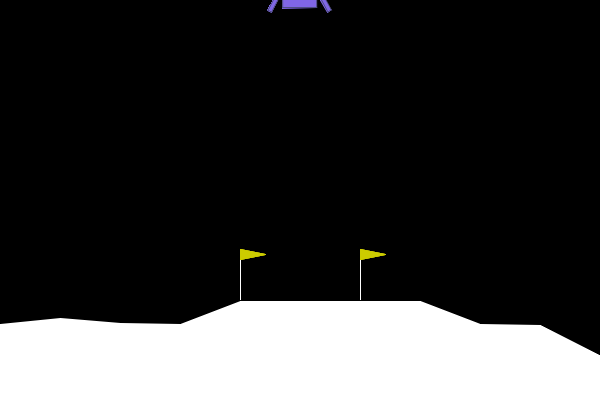

In [8]:
env.reset()
PIL.Image.fromarray(env.render())

In order to build our neural network later on we need to know the size of the state vector and the number of valid actions. We can get this information from our environment by using the `.observation_space.shape` and `action_space.n` methods, respectively.

In [9]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [10]:
# Reset the environment and get the initial state.
initial_state = env.reset()

Once the environment is reset, the agent can start taking actions in the environment by using the `.step()` method. Note that the agent can only take one action per time step. 

In the cell below you can select different actions and see how the returned values change depending on the action taken. Remember that in this environment the agent has four discrete actions available and we specify them in code by using their corresponding numerical value:

```python
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3
```

In [11]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, truncated, info = env.step(action)

# Display table with values. All values are displayed to 3 decimal places.
display_table(initial_state, action, next_state, reward, done)

Initial State:,"(array([0.002, 1.412, 0.199, 0.049, -0.002, -0.045, 0.000, 0.000], dtype=float32), {})"
Action:,Do nothing
Next State:,[0.004 1.413 0.198 0.023 -0.004 -0.044 0.000 0.000]
Reward Received:,0.211
Episode Terminated:,False


In practice, when we train the agent we use a loop to allow the agent to take many consecutive actions during an episode.

<a name="6"></a>
## 6 - Deep Q-Learning

In cases where both the state and action space are discrete we can estimate the action-value function iteratively by using the Bellman equation:

$$
Q_{i+1}(s,a) = R + \gamma \max_{a'}Q_i(s',a')
$$

This iterative method converges to the optimal action-value function $Q^*(s,a)$ as $i\to\infty$. This means that the agent just needs to gradually explore the state-action space and keep updating the estimate of $Q(s,a)$ until it converges to the optimal action-value function $Q^*(s,a)$. However, in cases where the state space is continuous it becomes practically impossible to explore the entire state-action space. Consequently, this also makes it practically impossible to gradually estimate $Q(s,a)$ until it converges to $Q^*(s,a)$.

In the Deep $Q$-Learning, we solve this problem by using a neural network to estimate the action-value function $Q(s,a)\approx Q^*(s,a)$. We call this neural network a $Q$-Network and it can be trained by adjusting its weights at each iteration to minimize the mean-squared error in the Bellman equation.

Unfortunately, using neural networks in reinforcement learning to estimate action-value functions has proven to be highly unstable. Luckily, there's a couple of techniques that can be employed to avoid instabilities. These techniques consist of using a ***Target Network*** and ***Experience Replay***. We will explore these two techniques in the following sections.

<a name="6.1"></a>
### 6.1 Target Network

We can train the $Q$-Network by adjusting it's weights at each iteration to minimize the mean-squared error in the Bellman equation, where the target values are given by:

$$
y = R + \gamma \max_{a'}Q(s',a';w)
$$

where $w$ are the weights of the $Q$-Network. This means that we are adjusting the weights $w$ at each iteration to minimize the following error:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}Q(s',a'; w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

Notice that this forms a problem because the $y$ target is changing on every iteration. Having a constantly moving target can lead to oscillations and instabilities. To avoid this, we can create
a separate neural network for generating the $y$ targets. We call this separate neural network the **target $\hat Q$-Network** and it will have the same architecture as the original $Q$-Network. By using the target $\hat Q$-Network, the above error becomes:

$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

where $w^-$ and $w$ are the weights the target $\hat Q$-Network and $Q$-Network, respectively.

In practice, we will use the following algorithm: every $C$ time steps we will use the $\hat Q$-Network to generate the $y$ targets and update the weights of the target $\hat Q$-Network using the weights of the $Q$-Network. We will update the weights $w^-$ of the the target $\hat Q$-Network using a **soft update**. This means that we will update the weights $w^-$ using the following rule:
 
$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$

where $\tau\ll 1$. By using the soft update, we are ensuring that the target values, $y$, change slowly, which greatly improves the stability of our learning algorithm.

<a name="ex01"></a>
### Exercise 1

In this exercise you will create the $Q$ and target $\hat Q$ networks and set the optimizer. Remember that the Deep $Q$-Network (DQN) is a neural network that approximates the action-value function $Q(s,a)\approx Q^*(s,a)$. It does this by learning how to map states to $Q$ values.

To solve the Lunar Lander environment, we are going to employ a DQN with the following architecture:



* A `Linear` layer with `state_size[0]` input units, `64` output units

* A `relu` activation function layer.

* A `Linear` layer with `64` input units, `64` output units

* A `relu` activation function layer.

* A `Linear` layer with `64` input units, `num_actions` output units


In the cell below you should create the $Q$-Network and the target $\hat Q$-Network using the model architecture described above. Remember that both the $Q$-Network and the target $\hat Q$-Network have the same architecture.

Lastly, you should set `Adam` as the optimizer with a learning rate equal to `ALPHA`. Recall that `ALPHA` was defined in the [Hyperparameters](#2) section. We should note that for this exercise you should use the already imported packages:

In [27]:
# Create the Q-Network
q_network = nn.Sequential(
    ### START CODE HERE ### 
    nn.Linear(state_size[0], 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions)
    ### END CODE HERE ### 
    )

# Create the target Q^-Network
target_q_network = nn.Sequential(
    ### START CODE HERE ### 
    nn.Linear(state_size[0], 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions)
    ### END CODE HERE ### 
    )

### START CODE HERE ### 
optimizer = optim.Adam(q_network.parameters(), lr=ALPHA)
### END CODE HERE ###

In [28]:
# Make them have the same initial parameters.
for target_param, param in zip(target_q_network.parameters(), q_network.parameters()):
    target_param.data.copy_(param.data)

<a name="6.2"></a>
### 6.2 Experience Replay

When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature. If the agent tries to learn from these consecutive experiences it can run into problems due to the strong correlations between them. To avoid this, we employ a technique known as **Experience Replay** to generate uncorrelated experiences for training our agent. Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning. The experience tuples $(S_t, A_t, R_t, S_{t+1})$ will be added to the memory buffer at each time step as the agent interacts with the environment.

For convenience, we will store the experiences as named tuples.

In [29]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

By using experience replay we avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.

<a name="7"></a>
## 7 - Deep Q-Learning Algorithm with Experience Replay

Now that we know all the techniques that we are going to use, we can put them together to arrive at the Deep Q-Learning Algorithm With Experience Replay.
<br>
<br>
<figure>
  <img src = "images/deep_q_algorithm.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">Fig 3. Deep Q-Learning with Experience Replay.</figcaption>
</figure>

<a name="ex02"></a>
### Exercise 2

In this exercise you will implement line ***12*** of the algorithm outlined in *Fig 3* above and you will also compute the loss between the $y$ targets and the $Q(s,a)$ values. In the cell below, complete the `compute_loss` function by setting the $y$ targets equal to:

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

Here are a couple of things to note:

* The `compute_loss` function takes in a mini-batch of experience tuples. This mini-batch of experience tuples is unpacked to extract the `states`, `actions`, `rewards`, `next_states`, and `done_vals`. You should keep in mind that these variables are *Pytorch Tensors* whose size will depend on the mini-batch size. For example, if the mini-batch size is `64` then both `rewards` and `done_vals` will be Pytorch Tensors with `64` elements.


* Using `if/else` statements to set the $y$ targets will not work when the variables are tensors with many elements. However, notice that you can use the `done_vals` to implement the above in a single line of code. To do this, recall that the `done` variable is a Boolean variable that takes the value `True` when an episode terminates at step $j+1$ and it is `False` otherwise. Taking into account that a Boolean value of `True` has the numerical value of `1` and a Boolean value of `False` has the numerical value of `0`, you can use the factor `(1 - done_vals)` to implement the above in a single line of code. Here's a hint: notice that `(1 - done_vals)` has a value of `0` when `done_vals` is `True` and a value of `1` when `done_vals` is `False`. 

Lastly, compute the loss by calculating the Mean-Squared Error (`MSE`) between the `y_targets` and the `q_values`. To calculate the mean-squared error you should use `F.mse_loss`:

In [32]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    """ 
    Calculates the loss.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (torch.nn.Sequential) PyTorch model for predicting the q_values
      target_q_network: (torch.nn.Sequential) PyTorch model for predicting the targets
          
    Returns:
      loss: (PyTorch Tensor) the Mean-Squared Error between the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    ### START CODE HERE ### 
    # Compute max Q^(s,a) using torch.max and target_q_network, pay attendion to the `dim` parameter.
    max_qsa = torch.max(target_q_network(next_states), dim=-1)[0]

    # Set y = R if episode terminates(done_vals are the boolean values indicating if the episode ended)
    # otherwise set y = R + γ max Q^(s,a).
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    # Get the q_values from q_network
    q_values = q_network(states)

    # Comprehend what `gather` does in the following line.
    q_values = q_values.gather(1, actions.long().unsqueeze(1))
    
    # Compute the loss using F.mse_loss between q_values and y_targets. You may need to use `unsqueeze` on y_targets.
    loss = F.mse_loss(q_values, y_targets.unsqueeze(1))
    ### END CODE HERE ### 

    return loss

<a name="8"></a>
## 8 - Update the Network Weights

We will use the `agent_learn` function below to implement lines ***12 -14*** of the algorithm outlined in [Fig 3](#7). The `agent_learn` function will update the weights of the $Q$ and target $\hat Q$ networks using a custom training loop.

The last line of this function updates the weights of the target $\hat Q$-Network using a [soft update](#6.1). If you want to know how this is implemented in code we encourage you to take a look at the `utils.update_target_network` function in the `utils` module.

In [33]:
def update_target_network(q_network, target_q_network):
    """
    Updates the weights of the target Q-Network using a soft update.
    
    The weights of the target_q_network are updated using the soft update rule:
    
                    w_target = (TAU * w) + (1 - TAU) * w_target
    
    where w_target are the weights of the target_q_network, TAU is the soft update
    parameter, and w are the weights of the q_network.
    
    Args:
        q_network (torch.nn.Module): 
            The Q-Network. 
        target_q_network (torch.nn.Module):
            The Target Q-Network.
    """
    TAU = 1e-3  # Soft update parameter.
    for target_param, param in zip(target_q_network.parameters(), q_network.parameters()):
        target_param.data.copy_(TAU * param.data + (1.0 - TAU) * target_param.data)

In [34]:
MINIBATCH_SIZE = 64  # Mini-batch size.

def get_experiences(memory_buffer):
    """
    Returns a random sample of experience tuples drawn from the memory buffer.

    Retrieves a random sample of experience tuples from the given memory_buffer and
    returns them as PyTorch Tensors. The size of the random sample is determined by
    the mini-batch size (MINIBATCH_SIZE). 
    
    Args:
        memory_buffer (deque):
            A deque containing experiences. The experiences are stored in the memory
            buffer as namedtuples: namedtuple("Experience", field_names=["state",
            "action", "reward", "next_state", "done"]).

    Returns:
        A tuple (states, actions, rewards, next_states, done_vals) where:

            - states are the starting states of the agent.
            - actions are the actions taken by the agent from the starting states.
            - rewards are the rewards received by the agent after taking the actions.
            - next_states are the new states of the agent after taking the actions.
            - done_vals are the boolean values indicating if the episode ended.

        All tuple elements are PyTorch Tensors whose shape is determined by the
        mini-batch size and the given Gym environment. For the Lunar Lander environment
        the states and next_states will have a shape of [MINIBATCH_SIZE, 8] while the
        actions, rewards, and done_vals will have a shape of [MINIBATCH_SIZE]. All
        PyTorch Tensors have elements with dtype=torch.float32.
    """

    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = torch.tensor(
        [e.state for e in experiences if e is not None], dtype=torch.float32, device=device)
    actions = torch.tensor(
        [e.action for e in experiences if e is not None], dtype=torch.float32, device=device)
    rewards = torch.tensor(
        [e.reward for e in experiences if e is not None], dtype=torch.float32, device=device)
    next_states = torch.tensor(
        [e.next_state for e in experiences if e is not None], dtype=torch.float32, device=device)
    done_vals = torch.tensor(
        [e.done for e in experiences if e is not None], dtype=torch.float32, device=device)
    return (states, actions, rewards, next_states, done_vals)

In [35]:
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Calculate the loss
    loss = compute_loss((states, actions, rewards, next_states, done_vals), gamma, q_network, target_q_network)

    # Compute gradients and update weights of q_network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Update the weights of target_q_network
    update_target_network(q_network, target_q_network)

<a name="9"></a>
## 9 - Train the Agent

We are now ready to train our agent to solve the Lunar Lander environment. In the cell below we will implement the algorithm in [Fig 3](#7) line by line (please note that we have included the same algorithm below for easy reference. This will prevent you from scrolling up and down the notebook):

* **Line 1**: We initialize the `memory_buffer` with a capacity of $N =$ `MEMORY_SIZE`. Notice that we are using a `deque` as the data structure for our `memory_buffer`.


* **Line 2**: We skip this line since we already initialized the `q_network` in [Exercise 1](#ex01).


* **Line 3**: We initialize the `target_q_network` by setting its weights to be equal to those of the `q_network`.


* **Line 4**: We start the outer loop. Notice that we have set $M =$ `num_episodes = 2000`. This number is reasonable because the agent should be able to solve the Lunar Lander environment in less than `2000` episodes using this notebook's default parameters.


* **Line 5**: We use the `.reset()` method to reset the environment to the initial state and get the initial state.


* **Line 6**: We start the inner loop. Notice that we have set $T =$ `max_num_timesteps = 1000`. This means that the episode will automatically terminate if the episode hasn't terminated after `1000` time steps.


* **Line 7**: The agent observes the current `state` and chooses an `action` using an $\epsilon$-greedy policy. Our agent starts out using a value of $\epsilon =$ `epsilon = 1` which yields an $\epsilon$-greedy policy that is equivalent to the equiprobable random policy. This means that at the beginning of our training, the agent is just going to take random actions regardless of the observed `state`. As training progresses we will decrease the value of $\epsilon$ slowly towards a minimum value using a given $\epsilon$-decay rate. We want this minimum value to be close to zero because a value of $\epsilon = 0$ will yield an $\epsilon$-greedy policy that is equivalent to the greedy policy. This means that towards the end of training, the agent will lean towards selecting the `action` that it believes (based on its past experiences) will maximize $Q(s,a)$. We will set the minimum $\epsilon$ value to be `0.01` and not exactly 0 because we always want to keep a little bit of exploration during training. If you want to know how this is implemented in code we encourage you to take a look at the `utils.get_action` function in the `utils` module.


* **Line 8**: We use the `.step()` method to take the given `action` in the environment and get the `reward` and the `next_state`. 


* **Line 9**: We store the `experience(state, action, reward, next_state, done)` tuple in our `memory_buffer`. Notice that we also store the `done` variable so that we can keep track of when an episode terminates. This allowed us to set the $y$ targets in [Exercise 2](#ex02).


* **Line 10**: We check if the conditions are met to perform a learning update. We do this by using our custom `utils.check_update_conditions` function. This function checks if $C =$ `NUM_STEPS_FOR_UPDATE = 4` time steps have occured and if our `memory_buffer` has enough experience tuples to fill a mini-batch. For example, if the mini-batch size is `64`, then our `memory_buffer` should have more than `64` experience tuples in order to pass the latter condition. If the conditions are met, then the `utils.check_update_conditions` function will return a value of `True`, otherwise it will return a value of `False`.


* **Lines 11 - 14**: If the `update` variable is `True` then we perform a learning update. The learning update consists of sampling a random mini-batch of experience tuples from our `memory_buffer`, setting the $y$ targets, performing gradient descent, and updating the weights of the networks. We will use the `agent_learn` function we defined in [Section 8](#8) to perform the latter 3.


* **Line 15**: At the end of each iteration of the inner loop we set `next_state` as our new `state` so that the loop can start again from this new state. In addition, we check if the episode has reached a terminal state (i.e we check if `done = True`). If a terminal state has been reached, then we break out of the inner loop.


* **Line 16**: At the end of each iteration of the outer loop we update the value of $\epsilon$, and check if the environment has been solved. We consider that the environment has been solved if the agent receives an average of `200` points in the last `100` episodes. If the environment has not been solved we continue the outer loop and start a new episode.

Finally, we wanted to note that we have included some extra variables to keep track of the total number of points the agent received in each episode. This will help us determine if the agent has solved the environment and it will also allow us to see how our agent performed during training. We also use the `time` module to measure how long the training takes. 

<br>
<br>
<figure>
  <img src = "images/deep_q_algorithm.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">Fig 4. Deep Q-Learning with Experience Replay.</figcaption>
</figure>
<br>

In [36]:
def get_action(q_values, epsilon=0.0):
    """
    Returns an action using an ε-greedy policy.

    This function will return an action according to the following rules:
        - With probability epsilon, it will return an action chosen at random.
        - With probability (1 - epsilon), it will return the action that yields the
        maximum Q value in q_values.
    
    Args:
        q_values (torch.Tensor):
            The Q values returned by the Q-Network. For the Lunar Lander environment
            this PyTorch Tensor should have a shape of [1, 4] and its elements should
            have dtype=torch.float32. 
        epsilon (float):
            The current value of epsilon.

    Returns:
        An action (numpy.int64). For the Lunar Lander environment, actions are
        represented by integers in the closed interval [0,3].
    """

    if random.random() > epsilon:
        ### START CODE HERE ###
        return torch.argmax(q_values).item()
        ### END CODE HERE ### 
    else:
        ### START CODE HERE ### 
        return random.randint(0, 3)
        ### END CODE HERE ### 

In [37]:
# %debug
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)
q_network = q_network.to(device)
target_q_network = target_q_network.to(device)
# Set the target network weights equal to the Q-Network weights
target_q_network.load_state_dict(q_network.state_dict())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state
    state, info = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = torch.from_numpy(np.expand_dims(state, axis=0))  # state needs to be the right shape for the q_network
        state_qn = state_qn.to(device)
        q_values = q_network(state_qn)
        action = get_action(q_values, epsilon)

        # Take action A and receive reward R and the next state S'
        next_state, reward, done, truncated, info = env.step(action)

        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        torch.save(q_network, 'lunar_lander_model.pt')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -160.81
Episode 200 | Total point average of the last 100 episodes: -94.379
Episode 300 | Total point average of the last 100 episodes: -66.97
Episode 400 | Total point average of the last 100 episodes: -19.23
Episode 500 | Total point average of the last 100 episodes: 135.43
Episode 600 | Total point average of the last 100 episodes: 196.77
Episode 607 | Total point average of the last 100 episodes: 200.16

Environment solved in 607 episodes!

Total Runtime: 775.11 s (12.92 min)


We can plot the total point history along with the moving average to see how our agent improved during training. If you want to know about the different plotting options available in the `utils.plot_history` function we encourage you to take a look at the `utils` module.

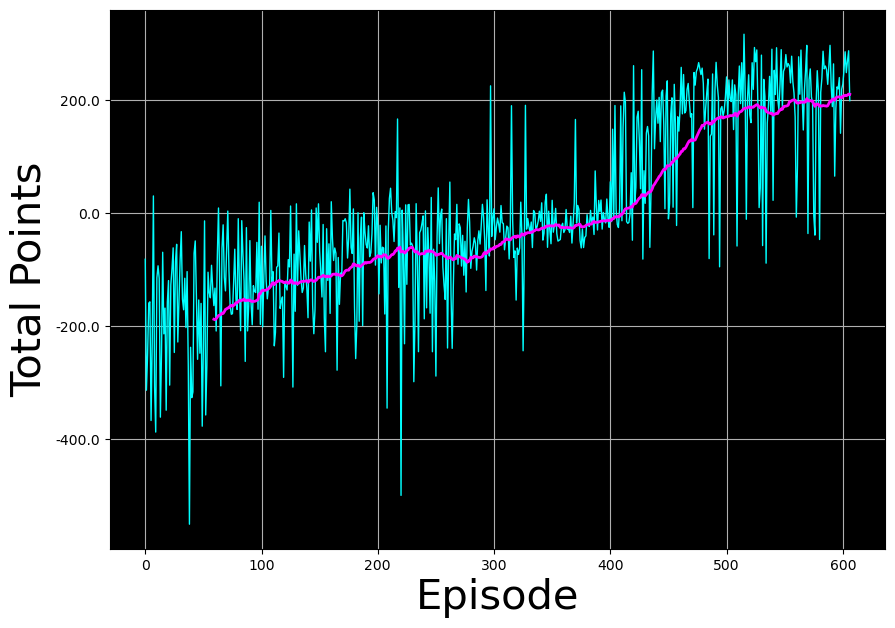

In [41]:
# Plot the total point history along with the moving average
plot_history(total_point_history)

<a name="10"></a>
## 10 - See the Trained Agent In Action

Now that we have trained our agent, we can see it in action. We will use the `utils.create_video` function to create a video of our agent interacting with the environment using the trained $Q$-Network. The `utils.create_video` function uses the `imageio` library to create the video. This library produces some warnings that can be distracting, so, to suppress these warnings we run the code below.

In [42]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In the cell below we create a video of our agent interacting with the Lunar Lander environment using the trained `q_network`. The video is saved to the `videos` folder with the given `filename`. We use the `utils.embed_mp4` function to embed the video in the Jupyter Notebook so that we can see it here directly without having to download it.

We should note that since the lunar lander starts with a random initial force applied to its center of mass, every time you run the cell below you will see a different video. If the agent was trained properly, it should be able to land the lunar lander in the landing pad every time, regardless of the initial force applied to its center of mass.

In [43]:
filename = "lunar_lander.mp4"

create_video(filename, env, q_network)
embed_mp4(filename)

[swscaler @ 0x6840600] Warning: data is not aligned! This can lead to a speed loss


<a name="11"></a>
## 11 - Congratulations!

You have successfully used Deep Q-Learning with Experience Replay to train an agent to land a lunar lander safely on a landing pad on the surface of the moon. Congratulations!

<a name="12"></a>
## 12 - References

If you would like to learn more about Deep Q-Learning, we recommend you check out the following papers.


* Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).


* Lillicrap, T. P., Hunt, J. J., Pritzel, A., et al. Continuous Control with Deep Reinforcement Learning. ICLR (2016).


* Mnih, V., Kavukcuoglu, K., Silver, D. et al. Playing Atari with Deep Reinforcement Learning. arXiv e-prints.  arXiv:1312.5602 (2013).